# Library

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import unidecode
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split

from scipy import sparse

# Data

## train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
df_train.comment_text = df_train.comment_text.str.replace("\n", "")
targets = [
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# Check NaN
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Test

In [4]:
df_test = pd.read_csv("../data/input/test.csv")
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
# Check NaN
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [6]:
df_test.loc[df_test.comment_text.isnull(), "comment_text"] = "nan"
df_test.comment_text = df_test.comment_text.str.replace("\n", "")

# Text cleaning

In [7]:
def clean_text(x, lemmatize=False):
    if type(x) == np.ndarray:
        x = pd.Series(x)
    # To lower
    x = x.str.lower()
    # Remove digits
    x = x.str.replace('\d+', '')
    # Remove url
    x = x.str.replace('http\S+', "")
    # Remove extra white spaces
    x = x.str.replace('[^\w\s]', ' ')
    x = x.str.replace(r"what's", "what is ")
    x = x.str.replace(r"\'s", " ")
    x = x.str.replace(r"\'ve", " have ")
    x = x.str.replace(r"can't", "cannot ")
    x = x.str.replace(r"n't", " not ")
    x = x.str.replace(r"i'm", "i am ")
    x = x.str.replace(r"\'re", " are ")
    x = x.str.replace(r"\'d", " would ")
    x = x.str.replace(r"\'ll", " will ")
    x = x.str.replace(r"\'scuse", " excuse ")
    # x = x.str.replace(r"!", " _exclamationmark_ ", x)
    # x = x.str.replace(r"\?", " _questionmark_ ", x)
    # Remove white space begin end string
    x = x.str.strip()
    if lemmatize:
        lemmatiser = WordNetLemmatizer()
        x = x.map(lambda sentence : " ".join([lemmatiser.lemmatize(word.strip()) for word in sentence.split(' ') if word not in ["", " ", "  "]]))
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    x = x.map(lambda sentence: sentence.translate(translator))
    # Remove stopwords
    stop_words = stopwords.words('english') + ["wikipedia", "wiki"]
    x = x.map(lambda sentence : " ".join([word for word in sentence.split(" ") if (word not in stop_words) and (len(word) > 1)]))
    return x.values

# Add features

In [8]:
def add_features(x):
    if type(x) == np.ndarray:
        df = pd.Series(x).rename("comment_text").to_frame()
    if type(x) == pd.core.series.Series:
        df = x.rename("comment_text").to_frame()
    df["n_interrogation"] = df.comment_text.str.count("\\?")
    df["n_exclamation"] = df.comment_text.str.count("\\!")
    df["n_dot"] = df.comment_text.str.count("\\.")
    df["n_coma"] = df.comment_text.str.count("\\,")
    df["n_upper"] = df.comment_text.str.count("[A-Z]")
    df["length"] = df.comment_text.map(len)
    df["n_words"] = df.comment_text.str.split().map(len)

    df["ratio_interrogation_n_words"] = df["n_interrogation"] / df["n_words"]
    df["ratio_exclamation_n_words"] = df["n_exclamation"] / df["n_words"]
    df["ratio_dot_n_words"] = df["n_dot"] / df["n_words"]
    df["ratio_coma_n_words"] = df["n_coma"] / df["n_words"]
    df["ratio_upper_n_words"] = df["n_upper"] / df["n_words"]

    df["ratio_interrogation_length"] = df["n_interrogation"] / df["length"]
    df["ratio_exclamation_length"] = df["n_exclamation"] / df["length"]
    df["ratio_dot_length"] = df["n_dot"] / df["length"]
    df["ratio_coma_length"] = df["n_coma"] / df["length"]
    df["ratio_upper_length"] = df["n_upper"] / df["length"]
    return df

# Train, Valid, Test

In [9]:
any_category_positive = np.sum(df_train[targets], 1)

print('Distribution of Total Positive Labels (important for validation)')
print(pd.value_counts(any_category_positive))

X_train, X_test, y_train, y_test = train_test_split(
    df_train.comment_text,
    df_train[targets],
    test_size=0.15,
    stratify=any_category_positive,
    random_state=777)
print('Training:', X_train.shape)
print('Testing:', X_test.shape)

Distribution of Total Positive Labels (important for validation)
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64
Training: (135635,)
Testing: (23936,)


# Baseline Model : Logistic Regression

In [10]:
def logistic_model(X_train,
                   y_train,
                   X_test,
                   y_test,
                   targets=targets,
                   penalty="l2"):
    metric = []
    for target in targets:
        print("_____________")
        print(target)
        model = LogisticRegression(penalty=penalty)
        model.fit(X_train, y_train[target])
        score = log_loss(
            y_pred=model.predict_proba(X_test)[:, 1], y_true=y_test[target])
        print(score)
        metric.append(score)
    return metric

## Raw tfidf

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=10000,
    strip_accents="unicode",
    stop_words=None,
    lowercase=False).fit(X_train)

In [12]:
logloss_raw_tfidf = logistic_model(
    tfidf_vectorizer.transform(X_train),
    y_train,
    tfidf_vectorizer.transform(X_test),
    y_test,
    targets=targets)

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.11982737293832783
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.027704352758409347
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.07193729926363092
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.013538341902874056
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08000075731235863
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.027220962534420072


## Clean text ?

In [13]:
X_train_clean = clean_text(X_train, lemmatize=False)
X_test_clean = clean_text(X_test, lemmatize=False)

In [14]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=10000,
    strip_accents="unicode",
    stop_words=None,
    lowercase=False).fit(X_train_clean)

In [15]:
logloss_clean_tfidf = logistic_model(
    tfidf_vectorizer.transform(X_train_clean),
    y_train,
    tfidf_vectorizer.transform(X_test_clean),
    y_test,
    targets=targets)

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.11796055987478306
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.028237114936472393
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06647745866028017
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.013870892349002503
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08112959721879329
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.026008022618485747


## Lemmatize ?

In [16]:
X_train_lemmatize = clean_text(X_train, lemmatize=True)
X_test_lemmatize = clean_text(X_test, lemmatize=True)

In [17]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=10000,
    strip_accents="unicode",
    stop_words=None,
    lowercase=False).fit(X_train_lemmatize)

In [18]:
logloss_lemmatize_tfidf = logistic_model(
    tfidf_vectorizer.transform(X_train_lemmatize),
    y_train,
    tfidf_vectorizer.transform(X_test_lemmatize),
    y_test,
    targets=targets)

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.1184151415319406
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.028060239956033996
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06883359869658855
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.013915213098383429
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08195909851593118
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.025198214712632096


## Add custom features ?

In [19]:
def process_data(X_train, X_test):
    features_train = add_features(X_train).drop("comment_text", axis=1)
    features_test = add_features(X_test).drop("comment_text", axis=1)
    X_train = clean_text(X_train)
    X_test = clean_text(X_test)
    tfidf = TfidfVectorizer(
        max_df=0.95,
        min_df=5,
        max_features=10000,
        strip_accents="unicode",
        stop_words=None,
        lowercase=False)
    tfidf = tfidf.fit(X_train)
    tfidf_train = tfidf.transform(X_train)
    tfidf_test = tfidf.transform(X_test)
    X_train = sparse.hstack((features_train, tfidf_train), format='csr')
    X_test = sparse.hstack((features_test, tfidf_test), format='csr')
    return X_train, X_test

In [20]:
X_train_features, X_test_features = process_data(X_train, X_test)

In [21]:
logloss_features_tfidf = logistic_model(
    X_train_features, y_train, X_test_features, y_test, targets=targets)

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2362721258122322
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.07040218702963633
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.27923121692350333
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.03078888845786367
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.18089172272493217
_____________
identity_hate
0.054797256073251754


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Compare results

In [22]:
df_scores = pd.DataFrame(
    {
        "raw_tfidf": logloss_raw_tfidf,
        "clean_tfidf": logloss_clean_tfidf,
        "lemmatize_tfidf": logloss_lemmatize_tfidf,
        "features_tfidf": logloss_features_tfidf
    },
    index=targets)[[
        "raw_tfidf", "clean_tfidf", "lemmatize_tfidf", "features_tfidf"
    ]]

In [23]:
df_scores

,raw_tfidf,clean_tfidf,lemmatize_tfidf,features_tfidf
toxic,0.119827,0.117961,0.118415,0.236272
severe_toxic,0.027704,0.028237,0.028060,0.070402
obscene,0.071937,0.066477,0.068834,0.279231
threat,0.013538,0.013871,0.013915,0.030789
insult,0.080001,0.081130,0.081959,0.180892
identity_hate,0.027221,0.026008,0.025198,0.054797


In [24]:
df_scores.mean()

raw_tfidf          0.056705
clean_tfidf        0.055614
lemmatize_tfidf    0.056064
features_tfidf     0.142064
dtype: float64

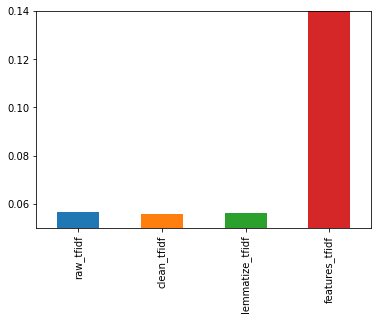

In [25]:
df_scores.mean().plot.bar(ylim = (0.05, 0.14))
plt.show()

# l1 vs. l2 penalization

## Model with l1 penalization

In [26]:
logloss_raw_tfidf_l1 = logistic_model(
    tfidf_vectorizer.transform(X_train),
    y_train,
    tfidf_vectorizer.transform(X_test),
    y_test,
    targets=targets,
    penalty="l1")

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.15298958218602882
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.036812284777016105
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.09423036936126825
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.01712908164990029
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.10077749847592225
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.03134383103169779


In [27]:
logloss_clean_tfidf_l1 = logistic_model(
    tfidf_vectorizer.transform(X_train_clean),
    y_train,
    tfidf_vectorizer.transform(X_test_clean),
    y_test,
    targets=targets,
    penalty="l1")

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.11700195375720668
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.028897172912196276
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06550267081289964
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.013477571897229155
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08336183414965058
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0275510822959626


In [28]:
logloss_lemmatize_tfidf_l1 = logistic_model(
    tfidf_vectorizer.transform(X_train_lemmatize),
    y_train,
    tfidf_vectorizer.transform(X_test_lemmatize),
    y_test,
    targets=targets,
    penalty="l1")

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.11352865740986211
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.02850831626202225
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06585197356623251
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.01335620458097217
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08200171141858031
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.025434175817938248


In [29]:
logloss_features_tfidf_l1 = logistic_model(
    X_train_features,
    y_train,
    X_test_features,
    y_test,
    targets=targets,
    penalty="l1")

_____________
toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.10977851563020359
_____________
severe_toxic


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0275303111101529
_____________
obscene


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06310395205243474
_____________
threat


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.012970640647165578
_____________
insult


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08106772442331558
_____________
identity_hate


/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.02658175007046561


In [30]:
df_scores_l1 = pd.DataFrame({
    "raw_tfidf": logloss_raw_tfidf_l1,
    "clean_tfidf": logloss_clean_tfidf_l1,
    "lemmatize_tfidf": logloss_lemmatize_tfidf_l1,
    "features_tfidf":logloss_features_tfidf_l1
}, index=targets)[["raw_tfidf", "clean_tfidf", "lemmatize_tfidf","features_tfidf"]]

In [31]:
df_scores_l1

,raw_tfidf,clean_tfidf,lemmatize_tfidf,features_tfidf
toxic,0.152990,0.117002,0.113529,0.109779
severe_toxic,0.036812,0.028897,0.028508,0.027530
obscene,0.094230,0.065503,0.065852,0.063104
threat,0.017129,0.013478,0.013356,0.012971
insult,0.100777,0.083362,0.082002,0.081068
identity_hate,0.031344,0.027551,0.025434,0.026582


In [32]:
df_scores_l1.mean()

raw_tfidf          0.072214
clean_tfidf        0.055965
lemmatize_tfidf    0.054780
features_tfidf     0.053505
dtype: float64

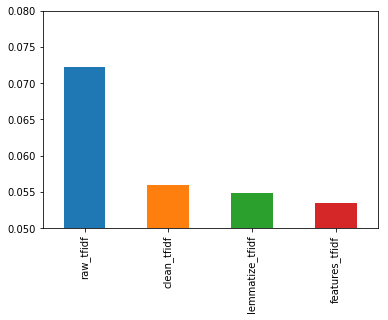

In [33]:
df_scores_l1.mean().plot.bar(ylim = (0.05, 0.08))
plt.show()

## Compare results l1 / l2

In [34]:
df_scores_l1.columns = [x + "_l1" for x in df_scores_l1.columns]

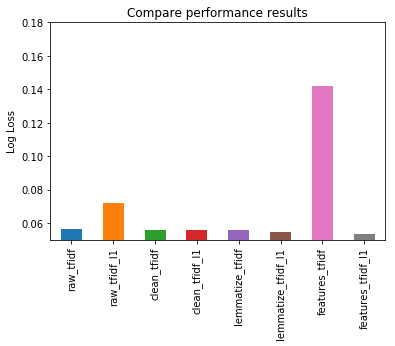

In [35]:
df_scores_l1_l2 = pd.concat(
    [df_scores, df_scores_l1], axis=1)[[
        "raw_tfidf", "raw_tfidf_l1", "clean_tfidf", "clean_tfidf_l1",
        "lemmatize_tfidf", "lemmatize_tfidf_l1", "features_tfidf",
        "features_tfidf_l1"
    ]]
df_scores_l1_l2.mean().plot.bar(ylim = (0.05, 0.18))
plt.ylabel("Log Loss")
plt.title("Compare performance results")
plt.show()

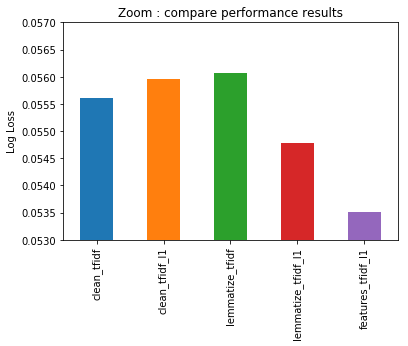

In [36]:
df_scores_l1_l2 = df_scores_l1_l2[["clean_tfidf", "clean_tfidf_l1",
        "lemmatize_tfidf", "lemmatize_tfidf_l1",
        "features_tfidf_l1"
    ]]
df_scores_l1_l2.mean().plot.bar(ylim=(0.053, 0.057))
plt.ylabel("Log Loss")
plt.title("Zoom : compare performance results")
plt.show()